https://github.com/mmuckley/torchkbnufft

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchkbnufft as tkbn
from skimage.data import shepp_logan_phantom

from mrisensesim import mrisensesim
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")


findfont: Font family ['migmix-1p-regular'] not found. Falling back to DejaVu Sans.
findfont: Font family ['migmix-1p-regular'] not found. Falling back to DejaVu Sans.


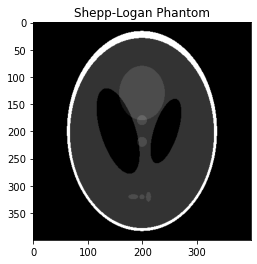

In [3]:
image = shepp_logan_phantom().astype(complex)
im_size = image.shape
plt.imshow(np.absolute(image))
plt.gray()
plt.title('Shepp-Logan Phantom')
plt.show()

In [4]:
image = torch.tensor(image).to(device).unsqueeze(0).unsqueeze(0)
print('image shape: {}'.format(image.shape))

image shape: torch.Size([1, 1, 400, 400])


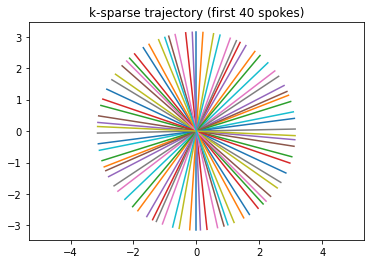

In [8]:
# create a k-space trajectory and plot it
spokelength = image.shape[-1] * 2
grid_size = (spokelength, spokelength)
nspokes = 405


ga = np.deg2rad(180 / ((1 + np.sqrt(5)) / 2))
kx = np.zeros(shape=(spokelength, nspokes))
ky = np.zeros(shape=(spokelength, nspokes))
ky[:, 0] = np.linspace(-np.pi, np.pi, spokelength)

for i in range(1, nspokes):
    kx[:, i] = np.cos(ga) * kx[:, i - 1] - np.sin(ga) * ky[:, i - 1]
    ky[:, i] = np.sin(ga) * kx[:, i - 1] + np.cos(ga) * ky[:, i - 1]
    
ky = np.transpose(ky)
kx = np.transpose(kx)
ktraj = np.stack((ky.flatten(), kx.flatten()), axis=0)

plt.plot(kx[:40, :].T, ky[:40, :].T)
plt.axis('equal')
plt.title('k-sparse trajectory (first 40 spokes)')
plt.show()

In [9]:
ktraj = torch.tensor(ktraj).to(device)
print('ktraj shape: {}'.format(ktraj.shape))

ktraj shape: torch.Size([2, 324000])


In [11]:
nufft_ob = tkbn.KbNufft(
    im_size=im_size,
    grid_size=grid_size,
).to(image)
adjnufft_ob = tkbn.KbInterpAdjoint(
    im_size=im_size,
    grid_size=grid_size,
).to(image)

print(nufft_ob)
print(adjnufft_ob)


KbNufft
----------------------------------------
buffers
	tensor: table_0, shape: (6145,)
	tensor: table_1, shape: (6145,)
	tensor: im_size, shape: (2,)
	tensor: grid_size, shape: (2,)
	tensor: n_shift, shape: (2,)
	tensor: numpoints, shape: (2,)
	tensor: offsets, shape: (36, 2)
	tensor: table_oversamp, shape: (2,)
	tensor: order, shape: (2,)
	tensor: alpha, shape: (2,)
	tensor: scaling_coef, shape: (400, 400)


KbInterpAdjoint
----------------------------------------
buffers
	tensor: table_0, shape: (6145,)
	tensor: table_1, shape: (6145,)
	tensor: im_size, shape: (2,)
	tensor: grid_size, shape: (2,)
	tensor: n_shift, shape: (2,)
	tensor: numpoints, shape: (2,)
	tensor: offsets, shape: (36, 2)
	tensor: table_oversamp, shape: (2,)
	tensor: order, shape: (2,)
	tensor: alpha, shape: (2,)



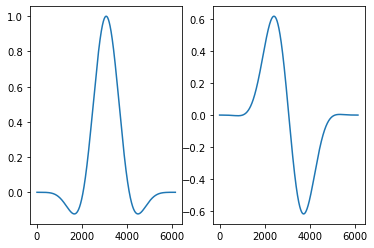

In [15]:
fig, axs = plt.subplots(1, 2)
axs.flat[0].plot(np.real(nufft_ob.table_0.cpu().numpy()))
axs.flat[1].plot(np.imag(nufft_ob.table_0.cpu().numpy()))
plt.show()

In [16]:
# calculate k-space data
kdata = nufft_ob(image, ktraj)
siglevel = torch.abs(kdata).mean()
kdata = kdata + (siglevel / 5) * torch.randn(kdata.shape).to(kdata)

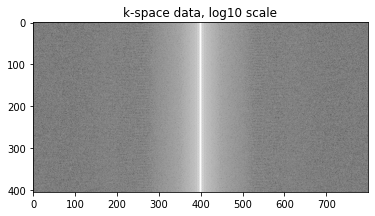

In [20]:
# plot the k-sparce data on log-scale
kdata_numpy = np.reshape(kdata.cpu().numpy(), (nspokes, spokelength))
plt.title('k-space data, log10 scale')
plt.imshow(np.log10(np.absolute(kdata_numpy)))

In [27]:
# adjnufft back
# method 1: no density compensation (blurry image)
image_blurry = adjnufft_ob(kdata, ktraj)

# method 2: use density compensation
dcomp = tkbn.calc_density_compensation_function(ktraj=ktraj, im_size=im_size)
image_sharp = adjnufft_ob(kdata * dcomp, ktraj)

In [36]:
kdata, ktraj

(tensor([[[-58.4639-5.4872e-14j,  12.6096-1.1576e+01j,   5.5417+4.4184e+00j,
            ..., -62.4237+1.4705e+01j, -32.6713+2.8863e+01j,
            -0.1089+1.3901e+01j]]], device='cuda:0', dtype=torch.complex128),
 tensor([[-3.1416, -3.1337, -3.1259,  ...,  1.7222,  1.7265,  1.7308],
         [ 0.0000,  0.0000,  0.0000,  ...,  2.6087,  2.6152,  2.6218]],
        device='cuda:0', dtype=torch.float64))

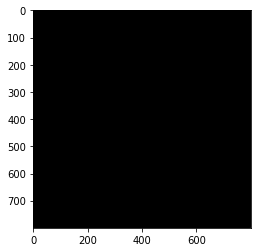

In [28]:
image_blurry_numpy = np.squeeze(image_blurry.cpu().numpy())
image_sharp_numpy = np.squeeze(image_sharp.cpu().numpy())

plt.figure(0)
plt.imshow(np.absolute(image_blurry_numpy))
plt.gray()

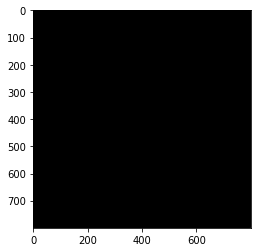

In [35]:
plt.imshow(np.absolute(np.squeeze(image_blurry).cpu().numpy()))